In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
import random

import keras
np.random.seed(1337)

from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D

%matplotlib inline

### Parameters for plotting model results ###
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 1.5
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'


def poly_profile_model(x, y, border_mode='same', inp_len=50, nodes=1, layers=1, filter_len=8, nbr_filters=40,
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3):
    model = Sequential()
    if layers >= 1:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    if layers >= 2:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(y.shape[1]))
    model.add(Activation('linear'))

    #compile the model
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam, )

    model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1)
    return model

def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors

def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

Using TensorFlow backend.


### Load data, make a train and test set based on total reads per UTR
The test set contains UTRs with the highest overall sequencing reads with the idea that increased reads will improve the resolution and a more accurate measure of mean ribosome load.

In [2]:
df = pd.read_csv('../data/egfp_unmod_1.csv')
df.sort_values('total_reads', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:280000]

# The training set has 260k UTRs and the test set has 20k UTRs.
e_test = df[:20000]
e_train = df[20000:]

seq_e_train = one_hot_encode(e_train,seq_len=50)
seq_e_test = one_hot_encode(e_test, seq_len=50)

rfractions = ['r' + str(x) for x in range(14)]
# Convert e_train into a matrix with relative polysome abundance for each UTR.
e_train = e_train[rfractions].values

__________________

### Train model
Using the hyperparameter-optimised values.

In [3]:
model = poly_profile_model(seq_e_train, e_train, nb_epoch=4,border_mode='same',
                   inp_len=50, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

W0719 14:02:00.640857 4632339904 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0719 14:02:00.680143 4632339904 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0719 14:02:00.687572 4632339904 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0719 14:02:00.791222 4632339904 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0719 14:02:00.805042 4632339904 deprecati

Epoch 1/4
260000/260000 [==============================] - 196s 753us/step - loss: 9.0456e-04
Epoch 2/4
260000/260000 [==============================] - 203s 780us/step - loss: 5.7029e-04
Epoch 3/4
260000/260000 [==============================] - 222s 855us/step - loss: 5.3166e-04
Epoch 4/4
260000/260000 [==============================] - 190s 733us/step - loss: 5.1640e-04


#### Evaluate model. Return predicted mean ribosome load in 'predictions'. Plot r-squared of each fraction.

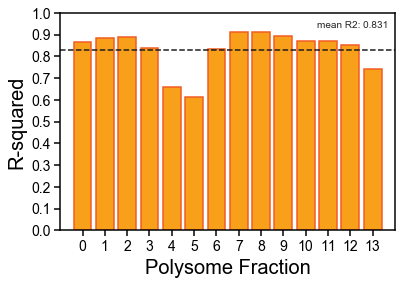

In [4]:
predictions = model.predict(seq_e_test)

scores = []
for i in range(14):
    pred = predictions[:,i]
    obs = e_test[rfractions[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=range(len(scores)),height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,14));
ax.set_xlim((-1,14))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('Polysome Fraction', size=20)
ax.set_ylabel('R-squared', size=20);

#### Save model

In [5]:
model.save('./saved_models/my_poly_profile_model.hdf5')

### Plotting test results

Choose random UTRs to look at observed / predicted polysome distribution.

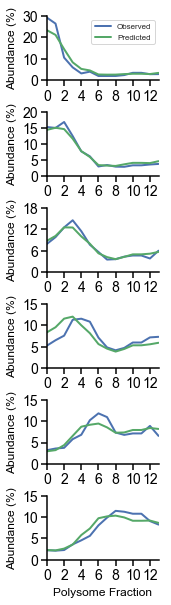

In [6]:
current_palette = sns.color_palette()
targets = np.arange(3, 9, 1)
ncols = 1
f, axes = plt.subplots(nrows=len(targets))
f.set_size_inches((2,10))
f.subplots_adjust(hspace=0.5)
row = 0
col = 0 
for target in targets:
    sub = e_test[(e_test['rl'] > target - 0.05) & (e_test['rl'] < target + 0.05)]
    ind = sub.sample(n=1).index[0]
    pred = predictions[ind,:] * 100
    obs = e_test.loc[ind,rfractions].values * 100
    
    majorLocator = ticker.MultipleLocator(2)
    
    ax = axes[row]
    ax.plot(obs, color=current_palette[0], label='Observed', linewidth=2)
    ax.plot(pred, color=current_palette[2], label='Predicted', linewidth=2)
    ax.xaxis.set_major_locator(majorLocator)
    ax.tick_params(axis='both', pad=3)

    ax.set_xlim(0,13)
    if row == 0:
        ax.set_ylim((0,0.30))
        ax.set_yticks(np.arange(0, 30.01, 10))
    if row == 1:
        ax.set_ylim((0,0.2))
        ax.set_yticks(np.arange(0, 20.01, 5))
    if row == 2:
        ax.set_ylim((0,0.18))
        ax.set_yticks(np.arange(0, 18.01, 6))
    if row == 3:
        ax.set_ylim((0,0.16))
        ax.set_yticks(np.arange(0, 15.01, 5))
    if row == 4:
        ax.set_ylim((0,0.15))
        ax.set_yticks(np.arange(0, 15.01, 5))
    if row == 5:
        ax.set_ylim((0,0.15))
        ax.set_yticks(np.arange(0, 15.01, 5))
       
    ax.set_ylabel('Abundance (%)')
    
    if row == 5:
        ax.set_xlabel('Polysome Fraction')

    if row == 0:
        ax.legend(loc='upper right', fontsize=8, markerscale=1)
    
    row += 1
    
sns.despine()